In [1]:
import os
import itertools
import pandas as pd
import numpy as np
from tqdm import tqdm
from mnist import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 数据读取
mndata = MNIST('./data')
train_valid_images, train_valid_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()
train_valid_images, train_valid_labels = np.array(train_valid_images), np.array(train_valid_labels)
test_images, test_labels = np.array(test_images), np.array(test_labels)

In [3]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_valid_images, train_valid_labels, test_size=0.3, random_state=0, stratify=train_valid_labels)

In [4]:
# 模型训练，两层全连接神经网络
# 激活函数
# 反向传播，loss以及梯度的计算
# 学习率下降策略
# L2正则化
# 优化器SGD
# 保存模型

# 模型使用 Linear -> ReLu -> Linear -> CrossEntropy -> SGD

class Linear():
    def __init__(self, input_dim, output_dim, bias=True):
        self._gradient = None
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.bias = bias

        self.w = np.random.uniform(-np.sqrt(1 / self.input_dim), np.sqrt(1 / self.input_dim), [input_dim, output_dim]) # input_dim * output_dim
        self.b = np.random.uniform(-np.sqrt(1 / self.input_dim), np.sqrt(1 / self.input_dim), [1, output_dim])
        if bias:
            self.w = np.vstack((self.w, self.b.reshape(1, -1)))
        self._parameters_dict = None

    def __call__(self, X, update_grad=False):
        num_sample, num_feature = X.shape
        if self.bias:
            num_feature += 1
            X = np.hstack((X, np.ones(num_sample).reshape(-1, 1))) # num_sample * input_dim
        
        if update_grad:
            self._update_gradient(grad_val=X.T)
        return np.dot(X, self.w) # num_sample * output_dim
    
    def _update_gradient(self, grad_val):
        self._gradient = grad_val

    @property
    def gradient(self):
        return self._gradient # input_dim * num_samples

    def _load_params(self, params):
        self.w = params['w'].data.numpy().T
        self.b = params['b'].data.numpy()
        if self.bias:
            self.w = np.vstack((self.w, self.b.reshape(1, -1)))

    @property
    def parameters(self):
        if self.bias:
            self._parameters_dict = {'w': self.w[:-1, :], 'b': self.w[-1, :]}
        else:
            self._parameters_dict = {'w': self.w}
        return self._parameters_dict
    
    def _update_params(self, update_value):
        self.w -= update_value

    def load(self, params_dict):
        self.w = params_dict['w']
        self.b = params_dict['b']
        if self.bias:
            self.w = np.vstack((self.w, self.b.reshape(1, -1)))
            
class ReLu():
    def __init__(self, inplace=False):
        self.inplace = inplace
        self._gradient = None
    
    def __call__(self, X, update_grad=False):
        if update_grad:
            self._update_gradient(grad_val=(X > 0))
        if self.inplace:
            np.maximum(X, 0, X)
        else:
            X = X.copy()
            return np.maximum(X, 0, X)
    
    def _update_gradient(self, grad_val):
        self._gradient = grad_val

    @property
    def gradient(self):
        return self._gradient

class LeakyReLu():
    def __init__(self, negative_slpoe=0.1, inplace=False):
        self.negative_slope = negative_slpoe
        self.inplace = inplace
        self._gradient = None
    
    def __call__(self, X, update_grad=False):
        if not self.inplace:
            X = X.copy()
        X[X > 0] = 1
        X[X < 0] = -self.negative_slope
        if update_grad:
            self._update_gradient(grad_val=X)
        if not self.inplace:
            return X

    def _update_gradient(self, grad_val):
        self._gradient = grad_val
    
    @property
    def gradient(self):
        return self._gradient
    
    def _train(self):
        self._train_mod = True
    
    def _eval(self):
        self._train_mod = False
        
class CrossEntropLoss():
    def __init__(self):
       self._gradient = None
       self._train_mod = False

    def __call__(self, predicts, labels):
        num_classes = predicts.shape[1]

        transform_labels = np.eye(num_classes)[labels]
        if num_classes > 2:
            transform_predicts = np.exp(predicts) / np.exp(predicts).sum(axis=1, keepdims=1)
        else:
            raise NotImplementedError()
        
        res = -transform_labels * np.log(transform_predicts)
        if self._train_mod:
            self._update_gradient(grad_val=transform_predicts - transform_labels)
        return np.sum(res) / res.shape[0]

    def _update_gradient(self, grad_val):
        self._gradient = grad_val

    @property
    def gradient(self):
        return self._gradient # num_samples * num_class

    @property
    def train_mod(self):
        return self._train_mod
    
    @train_mod.setter
    def train_mod(self, flag):
        self._train_mod = flag

class Model():
    def __init__(self, input_dim, hidden_dim, output_dim, loss_func):
        self.layer1 = Linear(input_dim, hidden_dim)
        self.relu = LeakyReLu(negative_slpoe=0.1)
        self.layer2 = Linear(hidden_dim, output_dim)
        self.loss_func = loss_func
        self._parameters_dict = self.parameters
        self._train_mod = False
    
    def __call__(self, X):
        X = self.layer1(X, update_grad=self._train_mod)
        X = self.relu(X, update_grad=self._train_mod)
        X = self.layer2(X, update_grad=self._train_mod)
        return X

    @property
    def parameters(self):
        self._parameters_dict = dict((k, v.parameters) for (k, v) in self.__dict__.items() if hasattr(v, 'parameters'))
        return self._parameters_dict
    
    # 当前版本未能实现计算图，所以需要手动编辑梯度
    def backward(self, l2_weight=0):
        self.gradient_dict = dict()
        if self.layer2.bias:
            self.gradient_dict['layer1'] = np.dot(self.layer1.gradient, self.relu.gradient * np.dot(self.loss_func.gradient, self.layer2.w[:-1, :].T))
        else:
            self.gradient_dict['layer1'] = np.dot(self.layer1.gradient, self.relu.gradient * np.dot(self.loss_func.gradient, self.layer2.w.T))
        self.gradient_dict['layer2'] = np.dot(self.layer2.gradient, self.loss_func.gradient)

        if self.layer1.bias:
            self.gradient_dict['layer1'][:-1, :] += l2_weight * self.layer1.w[:-1, :]
        else:
            self.gradient_dict['layer1'] += l2_weight * self.layer1.w
        
        if self.layer2.bias:
            self.gradient_dict['layer2'][:-1, :] += l2_weight * self.layer2.w[:-1, :]
        else:
            self.gradient_dict['layer2'] += l2_weight * self.layer2.w
    
    def sgd_step(self, lr=0.01, decay_rate=0.98, decay_step=1000, cur_step=0):
        # 使用指数化的步长缩减策略
        cur_lr = lr * decay_rate ** (cur_step / decay_step)
        for layer, params in self.gradient_dict.items():
            self.__dict__[layer]._update_params(cur_lr * params)
    
    def dump(self, path=None):
        if path is None:
            cur_path = os.getcwd()
            file_path = os.path.join(cur_path, 'model')
            os.makedirs(file_path, exist_ok=True)
        else:
            file_path = path

        for cur_layer in self.parameters:
            cur_layer_path = os.path.join(file_path, cur_layer)
            os.makedirs(cur_layer_path, exist_ok=True)
            for content in self.parameters[cur_layer]:
                self.parameters[cur_layer][content].dump(os.path.join(cur_layer_path, f'{content}.npy'))
            
    def load(self, path):
        param_dict = {}
        for layer in os.listdir(path):
            param_dict[layer] = dict()
            layer_path = os.path.join(path, layer)
            for content in os.listdir(layer_path):
                content_name = content.split('.')[0]
                layer_content = np.load(os.path.join(layer_path, content), allow_pickle=True)
                param_dict[layer][content_name] = layer_content
        for layer in param_dict:
            self.__dict__[layer].load(param_dict[layer])
    
    def train(self):
        self._train_mod = True
        self.loss_func.train_mod = True
    
    def eval(self):
        self._train_mod = False
        self.loss_func.train_mod = False

In [5]:
loss_func = CrossEntropLoss()

m = Model(input_dim=784, hidden_dim=64, output_dim=10, loss_func=loss_func)
train_index = [_ for _ in range(len(train_images))]
train_acc_list = []
valid_acc_list = []
test_acc_list = []

train_loss_list = []
valid_loss_list = []
test_loss_list = []
for epoch in tqdm(range(20000)):
    m.train()
    idx = np.random.choice(train_index)
    input_x = train_images[idx].reshape(1, -1)
    labels = train_labels[idx]
    predicts = m(input_x)
    
    train_loss = loss_func(predicts, labels)
    train_loss_list.append(train_loss)
    if epoch % 100 == 0:
        m.eval()
        valid_predict = m(valid_images)
        test_predict = m(test_images)

        valid_loss = loss_func(valid_predict, valid_labels)
        test_loss = loss_func(test_predict, test_labels)
        valid_loss_list.append(valid_loss)
        test_loss_list.append(test_loss)

        valid_acc = accuracy_score(valid_predict.argmax(axis=1), valid_labels)
        test_acc = accuracy_score(test_predict.argmax(axis=1), test_labels)
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)
    
    m.backward(l2_weight=0.0001)
    m.sgd_step(lr=0.05, cur_step=epoch, decay_step=500)

100%|██████████| 20000/20000 [01:03<00:00, 315.63it/s]


In [6]:
# 参数查找：学习率，隐藏层大小，正则化强度
def train_model(lr, hidden_dim, l2_weight):
    loss_func = CrossEntropLoss()

    m = Model(input_dim=784, hidden_dim=hidden_dim, output_dim=10, loss_func=loss_func)
    train_index = [_ for _ in range(len(train_images))]

    train_loss_list = []
    valid_loss_list = []

    for epoch in range(20000):
        m.train()
        idx = np.random.choice(train_index)
        input_x = train_images[idx].reshape(1, -1)
        labels = train_labels[idx]
        predicts = m(input_x)
        
        train_loss = loss_func(predicts, labels)
        train_loss_list.append(train_loss)

        # 加快计算速度每500个epoch进行一次validation的计算
        if epoch % 500 == 0:
            m.eval()
            valid_predict = m(valid_images)

            valid_loss = loss_func(valid_predict, valid_labels)
            valid_loss_list.append(valid_loss)
        
        m.backward(l2_weight=l2_weight)
        m.sgd_step(lr=lr, cur_step=epoch, decay_step=500)
    
    return min(valid_loss_list)

In [7]:
lr_list = [0.001, 0.01, 0.05, 0.1, 0.5]
hidden_dim_list = [32, 64, 128]
l2_weight_list = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

min_val_loss = None
best_lr, best_hidden_dim, best_l2_weight = None, None, None
for lr, hidden_dim, l2_weight in tqdm(itertools.product(lr_list, hidden_dim_list, l2_weight_list)):
    val_loss = train_model(lr=lr, hidden_dim=hidden_dim, l2_weight=l2_weight)
    if min_val_loss is None:
        min_val_loss = val_loss
        best_lr, best_hidden_dim, best_l2_weight = lr, hidden_dim, l2_weight
    else:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_lr, best_hidden_dim, best_l2_weight = lr, hidden_dim, l2_weight

75it [1:06:47, 53.44s/it]


In [9]:
loss_func = CrossEntropLoss()

m = Model(input_dim=784, hidden_dim=best_hidden_dim, output_dim=10, loss_func=loss_func)
train_index = [_ for _ in range(len(train_images))]
train_acc_list = []
valid_acc_list = []
test_acc_list = []

train_loss_list = []
valid_loss_list = []
test_loss_list = []
for epoch in tqdm(range(20000)):
    m.train()
    idx = np.random.choice(train_index)
    input_x = train_images[idx].reshape(1, -1)
    labels = train_labels[idx]
    predicts = m(input_x)
    
    train_loss = loss_func(predicts, labels)
    train_loss_list.append(train_loss)

    if epoch % 100 == 0:
        m.eval()
        valid_predict = m(valid_images)
        test_predict = m(test_images)

        valid_loss = loss_func(valid_predict, valid_labels)
        test_loss = loss_func(test_predict, test_labels)
        valid_loss_list.append(valid_loss)
        test_loss_list.append(test_loss)

        valid_acc = accuracy_score(valid_predict.argmax(axis=1), valid_labels)
        test_acc = accuracy_score(test_predict.argmax(axis=1), test_labels)
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)
    
    m.backward(l2_weight=best_l2_weight)
    m.sgd_step(lr=best_lr, cur_step=epoch, decay_step=500)

100%|██████████| 20000/20000 [01:12<00:00, 274.37it/s]


In [53]:
print(best_lr, best_hidden_dim, best_l2_weight)

0.05 128 0.0001


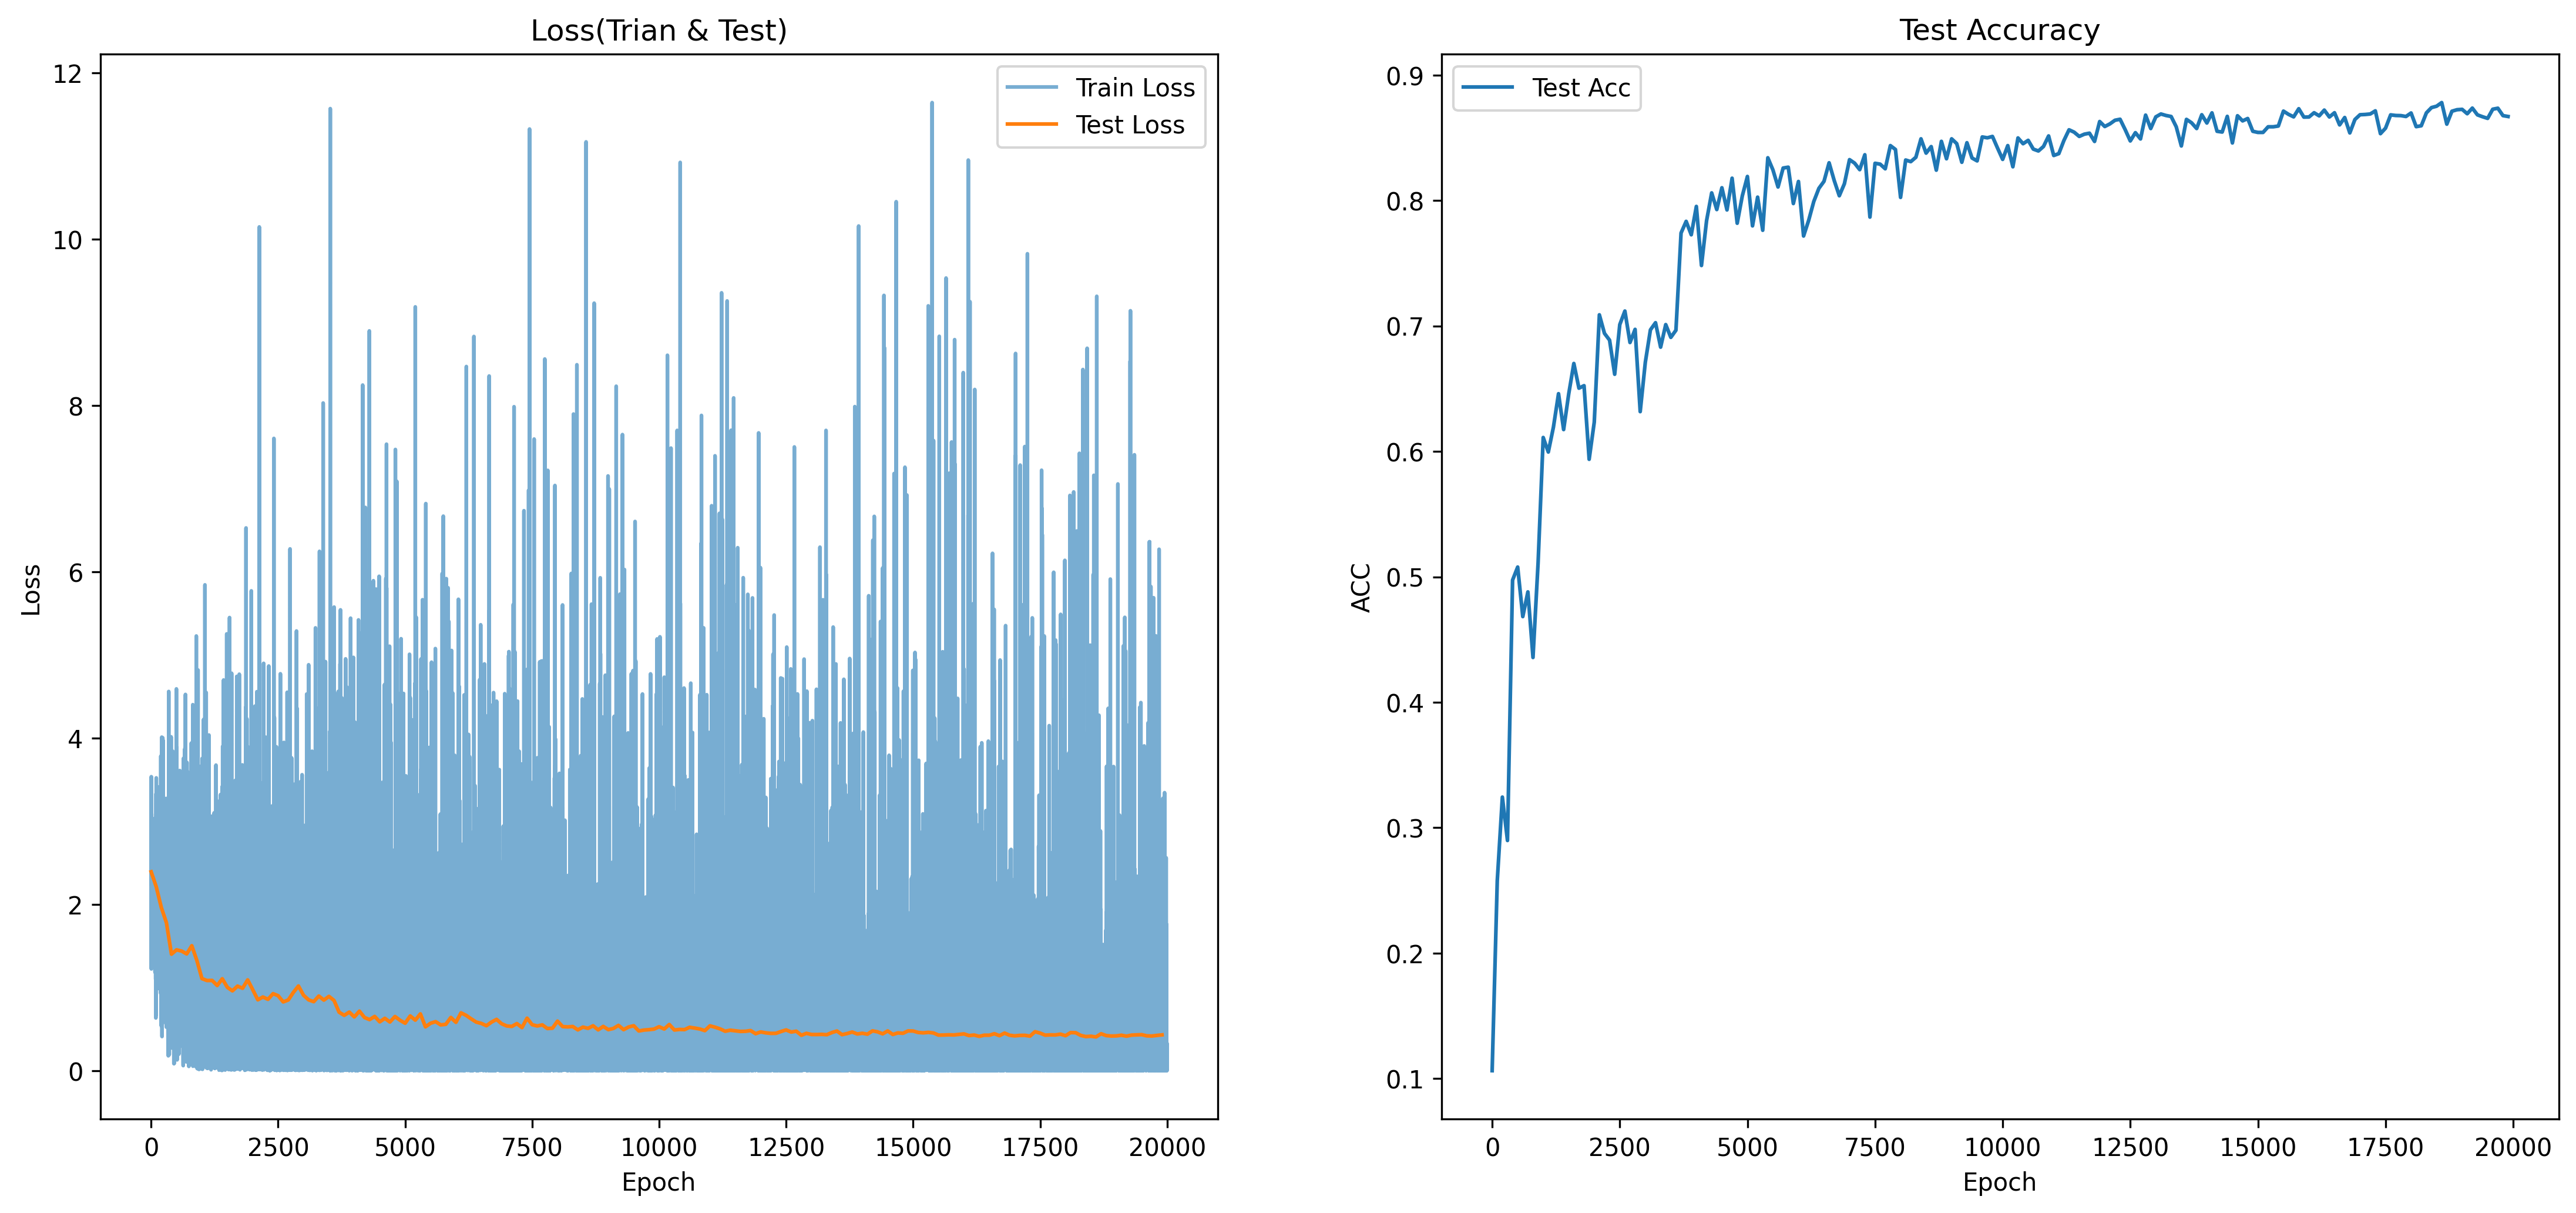

In [29]:
plt.figure(dpi=300, figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.title("Loss(Trian & Test)")
plt.plot(train_loss_list, alpha=0.6, label='Train Loss')
plt.plot([_ * 100 for _ in range(len(test_loss_list))], test_loss_list, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([_ * 100 for _ in range(len(test_acc_list))], test_acc_list, label="Test Acc")
plt.title('Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("ACC")
plt.legend()

In [30]:
# 模型存储及载入
m.dump()
load_m = Model(input_dim=784, hidden_dim=64, output_dim=10, loss_func=loss_func)
load_m.load('/Users/tsuilai/Desktop/课程代码/神经网络与深度学习/Assign1/model')

In [31]:
# 评估模型效果
def calc_metrics(model, dataset, label):
    predicts = model(dataset).argmax(axis=1)
    acc = accuracy_score(predicts, label)
    prec = precision_score(predicts, label, average='macro')
    rec = recall_score(predicts, label, average='macro')
    f1 = f1_score(predicts, label, average='macro')
    print(f"Accuracy: {acc:.4f} Precision: {prec:.4f} Recall: {rec:.4f} F1-Score: {f1:.4f}")

In [33]:
print("Train Set:")
calc_metrics(load_m, train_images, train_labels)
print("Valid Set:")
calc_metrics(load_m, valid_images, valid_labels)
print("Test Set:")
calc_metrics(load_m, test_images, test_labels)

Train Set:
Accuracy: 0.8718 Precision: 0.8712 Recall: 0.8727 F1-Score: 0.8708
Valid Set:
Accuracy: 0.8710 Precision: 0.8701 Recall: 0.8720 F1-Score: 0.8698
Test Set:
Accuracy: 0.8719 Precision: 0.8712 Recall: 0.8725 F1-Score: 0.8708


Text(0.5, 1.0, 'Layer 1 Parameters')

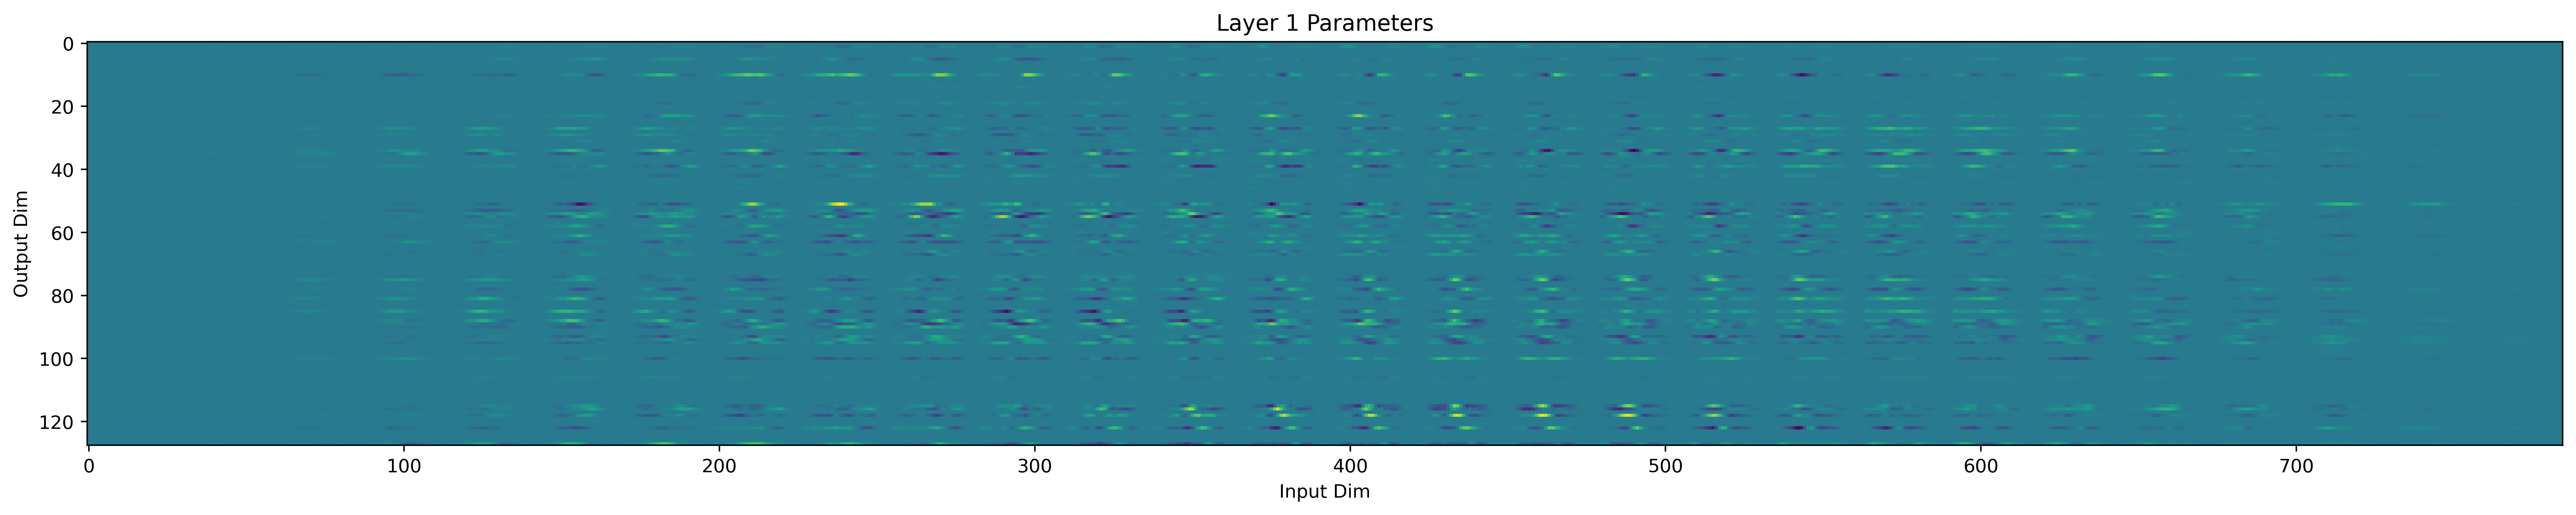

In [45]:
# 可视化网络参数
params_layer1 = m.layer1.w
params_layer2 = m.layer2.w

# 第一层参数可视化
plt.figure(dpi=400, figsize=(32,4))
plt.imshow(params_layer1.T)
plt.xlabel('Input Dim')
plt.ylabel('Output Dim')
plt.title('Layer 1 Parameters')

Text(0.5, 1.0, 'Layer 2 Parameters')

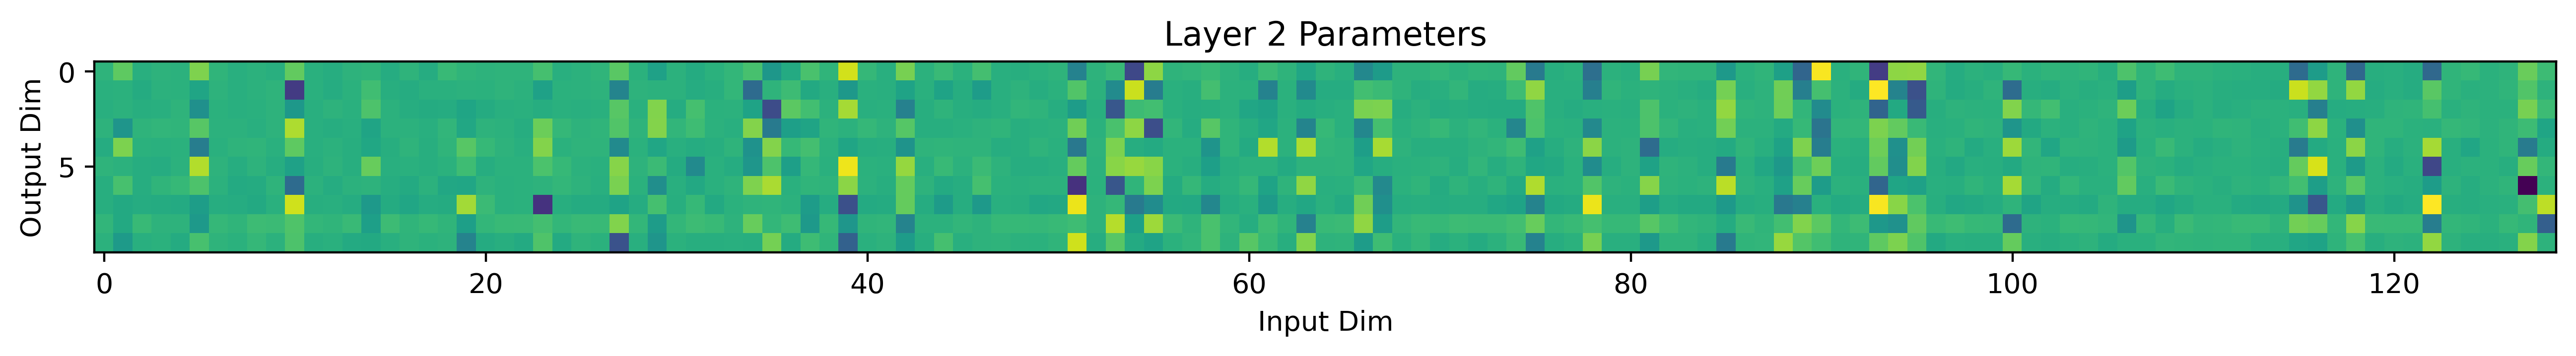

In [52]:
plt.figure(dpi=400, figsize=(16,10))
plt.imshow(params_layer2.T)
plt.xlabel('Input Dim')
plt.ylabel('Output Dim')
plt.title('Layer 2 Parameters')